In [4]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

/Users/sm/anaconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [5]:
mnist.keys()  # extra code – we only use data and target in this notebook

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [6]:
X, y = mnist.data, mnist.target

X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

y_train_5 = (y_train == '5')  # True for all 5s, False for all other digits
y_test_5 = (y_test == '5')

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [10]:
from sklearn.dummy import DummyClassifier
dummy_clf =DummyClassifier()
dummy_clf.fit(X_train, y_train_5)

print(any(dummy_clf.predict(X_train)))

False


In [11]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

Accuracy is genereally not a good performance measure for classificaiton. As we can see, only 10 % of images are 5,s so if you guessing that that an image is not a 5 you will have 90 % accuracy. (especially in skewed data)

Code down below:

clone(sgd_clf) creates a fresh clone of the classifier. This is done so that the original classifier (sgd_clf) is not affected by the training and can be used later.


In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3)  # add shuffle=True if the dataset is not
                                       # already shuffled
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))


0.95035
0.96035
0.9604


Stratified sampling:

Key function: Stratified sampling is used to sample the best samples from a population. Population is divided into a group called strata (contains homegenous information) and randomly sampling data from each stratum

Step 1) Divide the data (population) into different stratas. Remember a strata is just a group.

step 2) Chose of the sampling should be propertionte or dispropertionate 

step 3) Randomly sampling from each strata: if properpatione => then each strata in the sampel is equal irrespective of each other. IF it is dispropertionate each sample amount the proportion of the population size of the stratum

![Stratified Sampling](https://media.geeksforgeeks.org/wp-content/uploads/20210905231338/Stratified.JPG)

## Confusion Matrix 
note: Remember a perfect confusion matrix will only have true positives (TP) and true negative (TN)

In [13]:
from sklearn.model_selection import cross_val_predict 

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [14]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, sgd_clf.predict(X_train))

cm

array([[52316,  2263],
       [  601,  4820]])

As we can see 
- [True - Negatives: 52136 are succefully classfied as non-5's] I [False - Positives: 2263 are unfusuccefuly calssified as 5's]     
- True - Positives: 4820 are succefully classified as 5's I [False - Negatives: 601 are unsuccefully calssified as non 5's]   



## NOTE:

### remember that if the preceision is high, there is a low recall because the model is very picky and therefor only predicts the positive class when it is very sure
- 83,7 % of the time it detects an image that represents 5
- but it only detects 65 % of the images that represents a 5

#### simply: when it detects an image that represents a 5 it does with a precision of 83,7 % but it only detect 65 % images that are 5's





## Accuracy score and recall COMBINED INTO F12

Accuarcy: TP/ TP + FP

Recall: TP / TP + FN

theese are necessary to combine into f1: Harmonic mean of values (harmonic mean gives bigger weights for lower values). As a result F1 only becomes high when accuracy and recall is high.



![Optional Text](https://media.graphcms.com/output=format:jpg/output=format:webp/resize=width:667,height:566/K8KFL3DRmKQtheUw0N3c)

In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision_score(y_train_5, y_train_pred) 

0.8370879772350012

In [16]:
recall_score(y_train_5, y_train_pred) 

0.6511713705958311

In [17]:
f1_score(y_train_5, y_train_pred)


0.7325171197343846

The precision recall tradeoff simply implies that when precision increases the recall will decrease and vice versa. This is how SGDCClassifer makes classificaiton decisions. We need to find the perfect threshold to use, letøs try to use cross_Valpredict to get scores of all instances:

In [37]:
y_scores = cross_val_predict(sgd_clf,X_train, y_train_5, cv=3, method='decision_function')


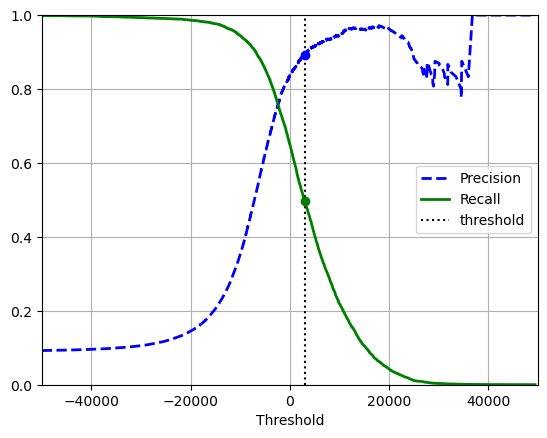

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

# extra code – this section just beautifies and saves Figure 3–5
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

#### From the graph above we see that precision around 90-92 % and around 48-50% 

We can also plot precision against recall directly

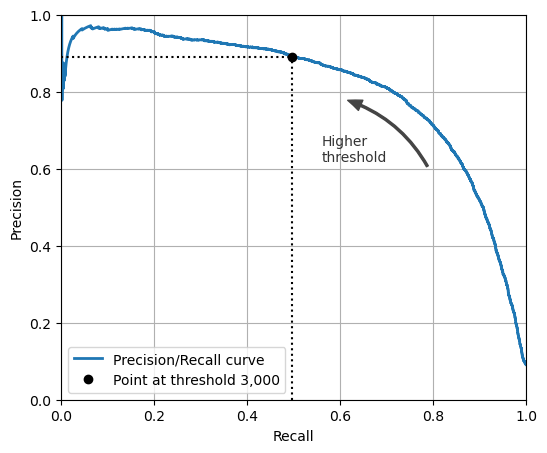

In [39]:
import matplotlib.patches as patches  # extra code – for the curved arrow

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# extra code – just beautifies and saves Figure 3–6
plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

### What does the graph above tell us

you can see that the graph starts to fall quickly at around 80 recall, a good idea is to choose a precision just before that drop

In [40]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

3370.019499144183

In [42]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

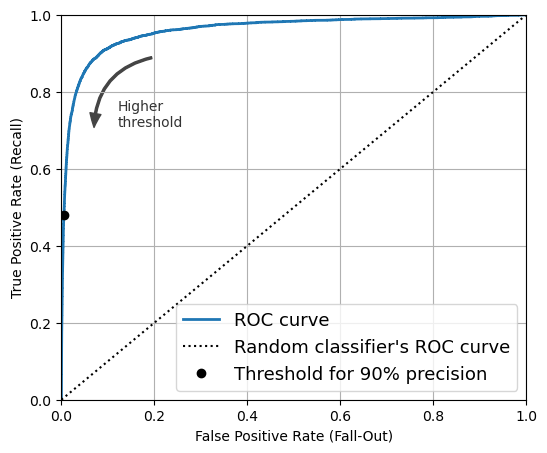

In [44]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.figure(figsize=(6, 5))  # extra code – not needed, just formatting
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")

# extra code – just beautifies and saves Figure 3–7
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13)

plt.show()